## **Bioprospecting analysis 2.0**

#### In this Notebook we will used the data generated in the [Bioprospecting analysis 1.0](https://github.com/pereiramemo/bioprospecting/blob/main/notebooks/bioprospecting-1.0.ipynb)
#### The tasks are organized in the following sections:  
#### [**0. Set env**](#section0)
#### [**1. Explore the BGC class composition**](#section1)
#### [**2. Explore the BGC's taxonomic composition**](#section2)


<a id='section0'></a>
**0. Set env**

Load the libraries

In [421]:
library(tidyverse)
library(lubridate)
library(ggdendro)
library(vegan)
setwd("/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting/notebooks/workdir/")
source("/home/epereira/workspace/dev/new_atlantis/repos/bioprospecting/aux_scripts/get_season_north.R")

Load the data

In [424]:
BGC_TBL <- read_tsv("outputs/bgc_abund/bgc_abund.tsv", 
                    col_names = F,
                    show_col_types = F)
colnames(BGC_TBL) <- c("sample", "seq_id", "edge", "bgc_class", "abund")

TAXA_TBL <- read_tsv("outputs/bgc_taxa/bgc_taxa_annot_lca_formatted.tsv", 
                     col_names = F,
                     show_col_types = F)
colnames(TAXA_TBL) <- c("sample", "seq_id", "tax_level", "tax_path")

METADATA_TBL <- read_csv("data/SOLA_metadata_extended.tsv",
                         col_names = T,
                         show_col_types = F)
METADATA_TBL$Season <- factor(get_season_north(METADATA_TBL$collection_date), 
                              levels = c("Winter", "Spring", "Summer", "Fall")) 


Let's see how these tables look like

In [353]:
head(BGC_TBL, n = 5)
head(TAXA_TBL, n = 5)
head(METADATA_TBL, n = 5)

sample,seq_id,edge,bgc_class,abund
<chr>,<chr>,<lgl>,<chr>,<dbl>
ERR2604071,ERR2604071__k119_144067,TRUE,phosphonate,1.041835
ERR2604071,ERR2604071__k119_154594,TRUE,betalactone,1.014010
ERR2604071,ERR2604071__k119_29665,TRUE,resorcinol,1.011193
ERR2604071,ERR2604071__k119_29813,TRUE,terpene,1.021466
ERR2604071,ERR2604071__k119_50764,TRUE,terpene,1.034165


sample,seq_id,tax_level,tax_path
<chr>,<chr>,<chr>,<chr>
ERR2604090,ERR2604090__k119_185408,order,-_cellular organisms;d_Bacteria;-_Terrabacteria group;-_Cyanobacteriota/Melainabacteria group;p_Cyanobacteriota;c_Cyanophyceae;o_Synechococcales
ERR2604090,ERR2604090__k119_153928,superkingdom,-_cellular organisms;d_Bacteria
ERR2604090,ERR2604090__k119_123795,family,-_cellular organisms;d_Bacteria;p_Pseudomonadota;c_Alphaproteobacteria;o_Rhodobacterales;f_Paracoccaceae
ERR2604090,ERR2604090__k119_131898,class,-_cellular organisms;d_Bacteria;p_Pseudomonadota;c_Gammaproteobacteria
ERR2604090,ERR2604090__k119_155472,phylum,-_cellular organisms;d_Bacteria;p_Pseudomonadota


samea_id,run_accession,experiment_accession,study_accession,tax_id,scientific_name,fastq_ftp,submitted_ftp,sra_ftp,Organism,⋯,geographic location (region and locality),investigation type,nitrite,project name,sequencing method,silicate,ph,ENA-FIRST-PUBLIC,ENA-LAST-UPDATE,Season
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<date>,<date>,<fct>
SAMEA4699777,ERR2604071,ERX2620727,PRJEB26919,1561972,seawater metagenome,ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/001/ERR2604071/ERR2604071_1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/001/ERR2604071/ERR2604071_2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604071/1_TAAGGCGA-CTCTCTAT_L001_R1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604071/1_TAAGGCGA-CTCTCTAT_L001_R2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/err/ERR260/001/ERR2604071,1561972,⋯,SOLA station Bay of Banyuls sur Mer (France) in northwestern Mediterranean,metagenome,"0,18",SOLA,Illumina,"1,15",831.00,2018-05-30,2018-11-12,Winter
SAMEA4699778,ERR2604072,ERX2620728,PRJEB26919,1561972,seawater metagenome,ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/002/ERR2604072/ERR2604072_1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/002/ERR2604072/ERR2604072_2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604072/2_TAAGGCGA-TATCCTCT_L002_R1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604072/2_TAAGGCGA-TATCCTCT_L002_R2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/err/ERR260/002/ERR2604072,1561972,⋯,SOLA station Bay of Banyuls sur Mer (France) in northwestern Mediterranean,metagenome,"0,41",SOLA,Illumina,"1,92",819.00,2018-05-30,2018-11-12,Winter
SAMEA4699779,ERR2604073,ERX2620729,PRJEB26919,1561972,seawater metagenome,ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/003/ERR2604073/ERR2604073_1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/003/ERR2604073/ERR2604073_2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604073/3_TAAGGCGA-GTAAGGAG_L003_R1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604073/3_TAAGGCGA-GTAAGGAG_L003_R2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/err/ERR260/003/ERR2604073,1561972,⋯,SOLA station Bay of Banyuls sur Mer (France) in northwestern Mediterranean,metagenome,"0,16",SOLA,Illumina,"3,26",825.00,2018-05-30,2018-11-12,Winter
SAMEA4699780,ERR2604074,ERX2620730,PRJEB26919,1561972,seawater metagenome,ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/004/ERR2604074/ERR2604074_1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/004/ERR2604074/ERR2604074_2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604074/4_TAAGGCGA-ACTGCATA_L004_R1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604074/4_TAAGGCGA-ACTGCATA_L004_R2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/err/ERR260/004/ERR2604074,1561972,⋯,SOLA station Bay of Banyuls sur Mer (France) in northwestern Mediterranean,metagenome,"0,14",SOLA,Illumina,"0,6",8.37,2018-05-30,2018-11-12,Winter
SAMEA4699781,ERR2604075,ERX2620731,PRJEB26919,1561972,seawater metagenome,ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/005/ERR2604075/ERR2604075_1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/fastq/ERR260/005/ERR2604075/ERR2604075_2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604075/5_TAAGGCGA-AAGGAGTA_L005_R1.fastq.gz;ftp.sra.ebi.ac.uk/vol1/run/ERR260/ERR2604075/5_TAAGGCGA-AAGGAGTA_L005_R2.fastq.gz,ftp.sra.ebi.ac.uk/vol1/err/ERR260/005/ERR2604075,1561972,⋯,SOLA station Bay of Banyuls sur Mer (France) in northwestern Mediterranean,metagenome,"0,15",SOLA,Illumina,"0,2",84.00,2018-05-30,2018-11-12,Winter


<a id='section1'></a>
**1. Explore the BGC class composition**

First we have to collapse the BGC class abundance per sample.

In [425]:
BGC_TBL_coll <- BGC_TBL %>%
                group_by(sample, bgc_class) %>%
                summarize(abund = sum(abund)) %>%
                group_by(sample) %>%
                mutate(abund_rel = 100*abund/sum(abund))

head(BGC_TBL_coll)

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


sample,bgc_class,abund,abund_rel
<chr>,<chr>,<dbl>,<dbl>
ERR2604071,betalactone,1.014010,14.109479
ERR2604071,phosphonate,1.041835,14.496650
ERR2604071,resorcinol,1.011193,14.070280
ERR2604071,terpene,4.119691,57.323591
ERR2604073,betalactone,3.185653,23.041487
ERR2604073,hserlactone,1.068975,7.731779


Let's see some basic stats:

In [426]:
bgc_class_n <- BGC_TBL_coll$bgc_class %>% unique %>% length
bgc_seqs_n <- BGC_TBL$seq_id %>% unique %>% length
bgc_complete_seqs_n <- sum(!BGC_TBL$edge)

print(paste("Number of BGC classes:", bgc_class_n, sep = " "))
print(paste("Number of BGC sequences:", bgc_seqs_n, sep = " "))
print(paste("Number of complete BGC sequences:", bgc_complete_seqs_n, sep = " "))

[1] "Number of BGC classes: 16"
[1] "Number of BGC sequences: 744"
[1] "Number of complete BGC sequences: 75"


The complete BGC sequence from the following classes:

In [427]:
bgc_complete_seqs_counts <- BGC_TBL %>% filter(edge == F) %>% select(bgc_class) %>% table()
as.data.frame(bgc_complete_seqs_counts)

bgc_class,Freq
<fct>,<int>
arylpolyene,1
betalactone,5
hserlactone,3
phosphonate,1
RiPP-like,7
siderophore,1
T1PKS,1
terpene,56


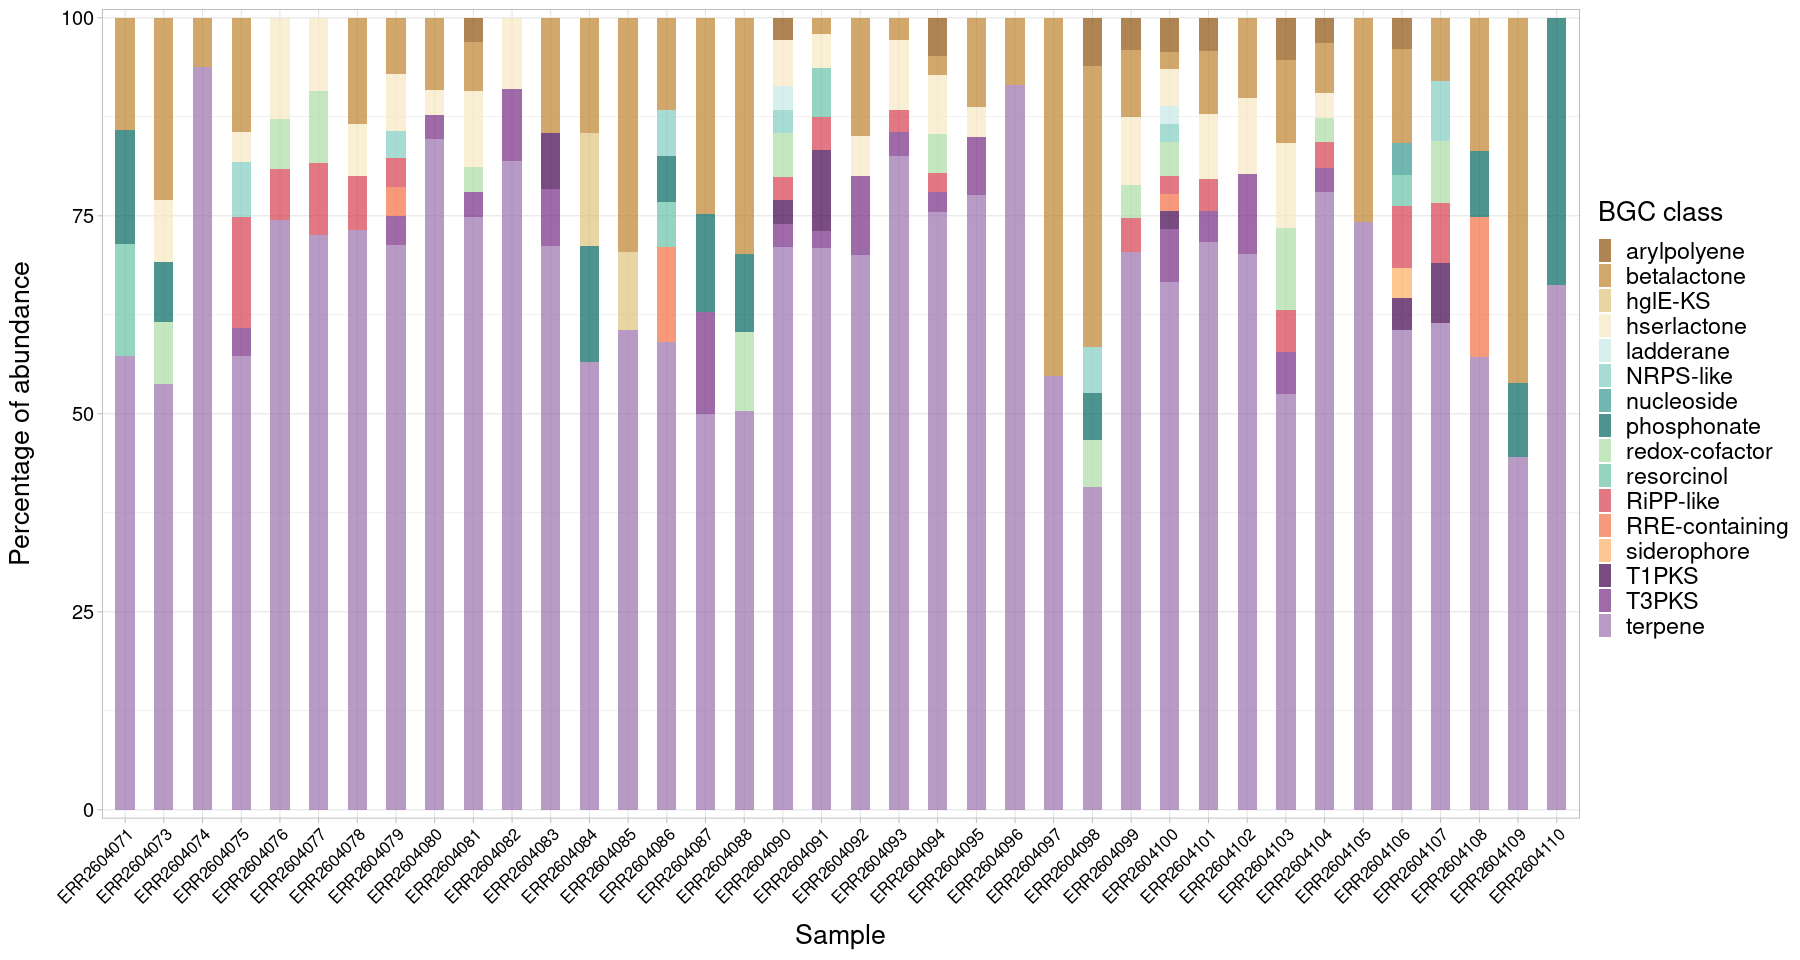

In [428]:
bgc_colors <-  c('#8c510a','#bf812d','#dfc27d','#f6e8c3',
                 '#c7eae5','#80cdc1','#35978f','#01665e',
                 '#abdda4','#66c2a5', '#d53e4f','#f46d43',
                 '#fdae61','#40004b','#762a83', '#9970ab')
text_size <- 12

barplot <- ggplot(BGC_TBL_coll, aes(x = sample, y = abund_rel, fill = bgc_class)) + 
           geom_bar(stat = "identity", width = 0.5, alpha = 0.7) +
           xlab("Sample") +
           ylab("Percentage of abundance") +
           scale_fill_manual(name="BGC class",
                             values = bgc_colors) +
           scale_y_continuous(expand=c(0,0.1), limits = c(-1,101)) +
           theme_light() +
           theme( 
                 axis.text.x = element_text(size = text_size -2, angle = 45, hjust = 1, color = "black"),
                 axis.text.y = element_text(size = text_size, color = "black"),
                 axis.title.x = element_text(size = text_size + 4, color = "black",
                                             margin = margin(10,0,0,0)),
                 axis.title.y = element_text(size = text_size + 4, color = "black",
                                             margin = margin(0,15,0,0)),
                 legend.text = element_text(size = text_size +2, color = "black"),
                 legend.title = element_text(size = text_size +4 , color = "black"),
                 legend.position = "right",
                 legend.margin = ggplot2::margin(0,0,-5,0),
                 strip.background = element_blank(),
                 strip.text = element_text(color = "black", size = text_size)) +
                 guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) 

options(repr.plot.width=15, repr.plot.height=8)
barplot

As expected for surface marine environment, we observed a high abundance of terpenes. Similar results have been observed by [Paoli 2022](https://www.nature.com/articles/s41586-022-04862-3) and [Pereira 2020](https://www.biorxiv.org/content/10.1101/2021.01.20.427441v1). This finding could be explained by a higher abundance of carotenoid pigments involved in light harvesting and oxidative stress protection processes.

Let's see how a two-way clustering heatmap looks like.  
First, we generate the clusters.

In [430]:
BGC_TBL_coll_wide <- BGC_TBL_coll %>%
                     select(-abund_rel) %>%
                     pivot_wider(names_from = bgc_class, 
                                 values_from = abund, 
                                 values_fill = 0) %>%
                     left_join(x =., 
                               y = METADATA_TBL %>% select(run_accession, collection_date),
                               by = c("sample" = "run_accession")) %>%
                     ungroup %>%
                     select(-sample) %>%
                     column_to_rownames("collection_date")

BGC_TBL_norm <- decostand(BGC_TBL_coll_wide, method = "hellinger")
sample_clust <- hclust(vegdist(BGC_TBL_norm, method = "euclidean"), method="ward.D")
bgc_clust <- hclust(vegdist(t(BGC_TBL_norm), method = "euclidean"), method="ward.D")

sample_clust_dendro <- sample_clust %>%
                       as.dendrogram
bgc_clust_dendro <- bgc_clust %>%
                    as.dendrogram 

sample_clust_data <- dendro_data(sample_clust_dendro)
bgc_clust_data <- dendro_data(bgc_clust_dendro)


And the dendro plots.

In [432]:
sample_clust_metadata <- data.frame(collection_date = label(sample_clust_data)$label %>% 
                                    as.character,
                                    x = label(sample_clust_data)$x,
                                    y = label(sample_clust_data)$y) %>%
                         mutate(Season = get_season_north(collection_date))

season_colors <- c("#154360", "#3c7810", "#c93f1b","#98482b")

sample_clust_plot <- ggplot(segment(sample_clust_data)) +
                     coord_flip() +
                     geom_segment(aes(x=x, y=y, xend=xend, yend=yend), linewidth = 0.2) +
                     geom_point(data = sample_clust_metadata, 
                                aes(x = x , y = y, colour = Season),
                                    shape = 15, size = 4, alpha = 0.8) +
                     scale_colour_manual(values=season_colors) +
                     theme_void() +
                     theme(plot.margin = unit(c(-1,1,6.5,0.2), "lines"))

bgc_clust_plot <- ggplot(segment(bgc_clust_data)) +
                  geom_segment(aes(x=x, y=y, xend=xend, yend=yend), linewidth = 0.2) +
                  theme_void() +
                  theme(plot.margin = unit(c(1,15.5,0,9), "lines"))

Now the heatmap.

In [438]:
BGC_TBL_norm_long <- BGC_TBL_norm %>%
                     as.data.frame %>%
                     rownames_to_column("collection_date") %>%
                     pivot_longer(names_to = "bgc_class", 
                                  values_to = "abund", 
                                  cols = 2:(dim(BGC_TBL_norm)[2]+1))
                     
BGC_TBL_norm_long$collection_date <- factor(BGC_TBL_norm_long$collection_date, 
                                           levels = sample_clust$labels[sample_clust$order])
BGC_TBL_norm_long$bgc_class <- factor(BGC_TBL_norm_long$bgc_class, 
                                      levels = bgc_clust$labels[bgc_clust$order])

heatmap <- ggplot(BGC_TBL_norm_long, aes(x = collection_date, y = bgc_class, fill = abund)) + 
           geom_tile() +
           xlab("Collection date") +
           ylab("BGC class") +
           theme_light() +
           theme( 
                 axis.text.x = element_text(size = text_size, angle = 45, hjust = 1, color = "black"),
                 axis.text.y = element_text(size = text_size, color = "black"),
                 axis.title.x = element_text(size = text_size + 4, color = "black",
                                             margin = margin(10,0,0,0)),
                 axis.title.y = element_text(size = text_size + 4, color = "black",
                                             margin = margin(0,15,0,0)),
                 legend.text = element_text(size = text_size +2, color = "black"),
                 legend.title = element_text(size = text_size +4 , color = "black"),
                 legend.position = c(1.3,0.95),
                 legend.margin = ggplot2::margin(0,0,-5,0),
                 strip.background = element_blank(),
                 strip.text = element_text(color = "black", size = text_size),
                 plot.margin = unit(c(0.2,0,1,1), "lines")) +
            guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) +
            scale_fill_gradient(low="white", high="#01665e", name = "% of abundance") +
            coord_flip()


Merge all plots

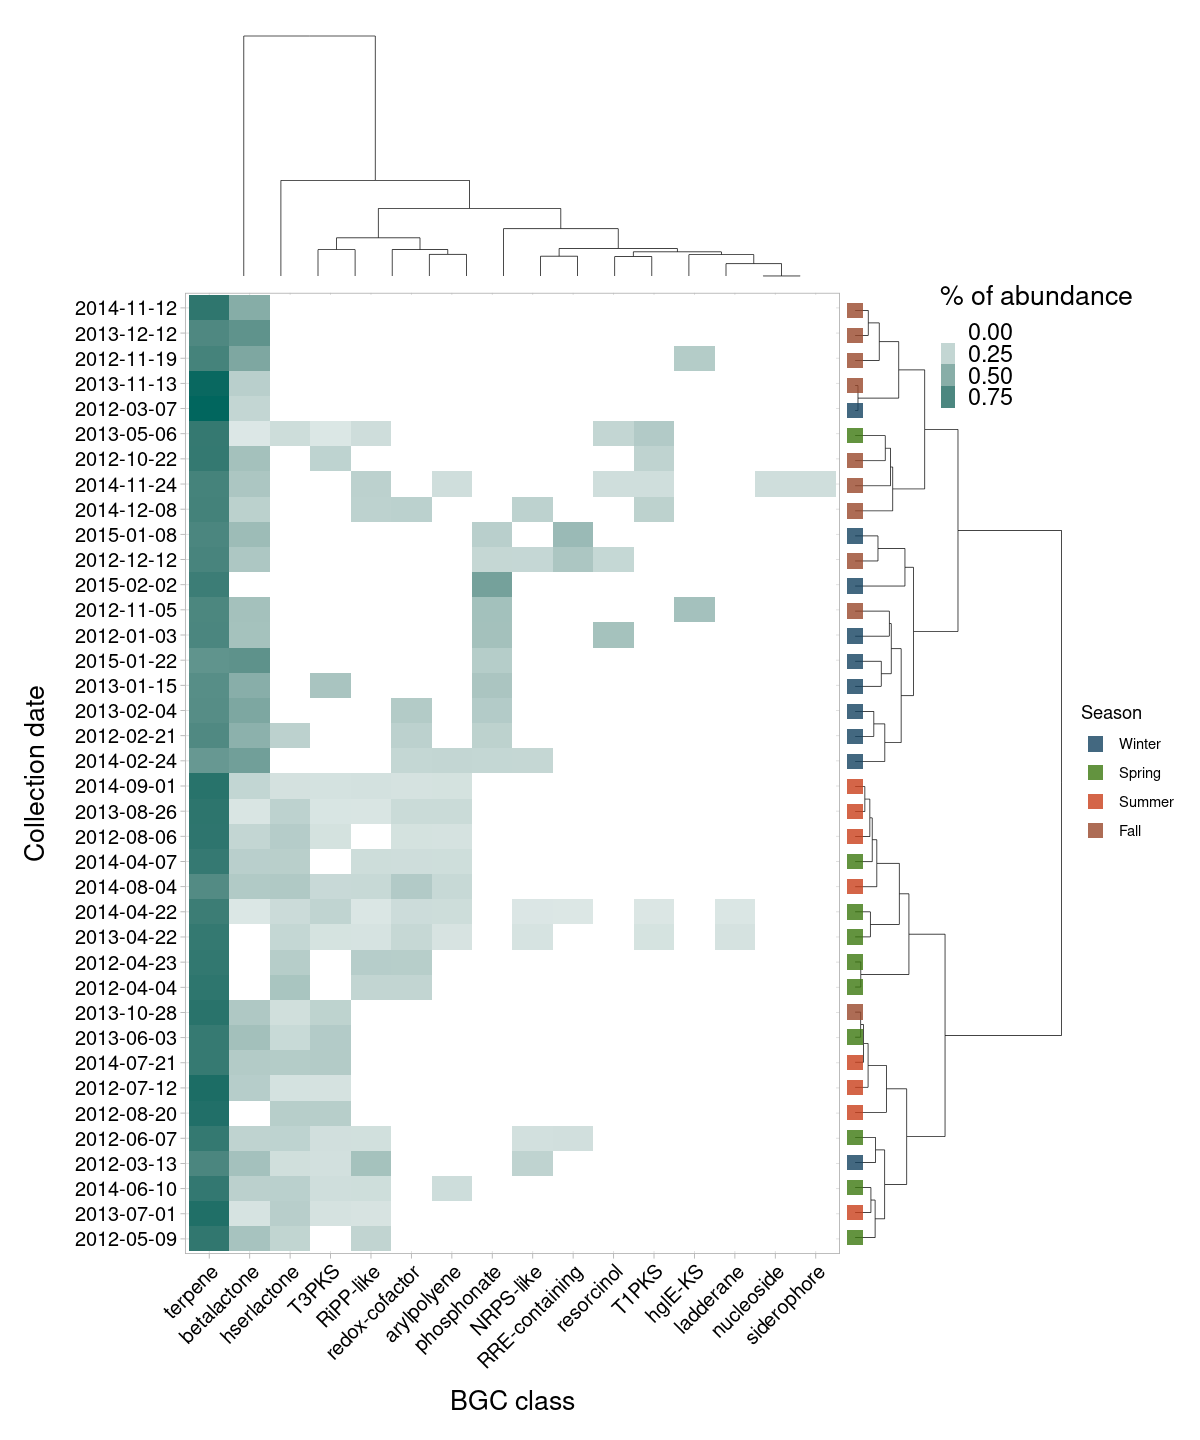

In [439]:
heatmap_1 <- ggarrange(heatmap, sample_clust_plot,
                       nrow = 1, ncol = 2, 
                       widths = c(0.7, 0.3))

heatmap_1and2 <- ggarrange(bgc_clust_plot, heatmap_1,    
                           nrow = 2, ncol = 1,  
                           heights = c(0.2, 0.8))

options(repr.plot.width=10, repr.plot.height=12)
heatmap_1and2

Interestingly, this shows two main clusters separating the semesters winter and fall from summer and spring.

<a id='section2'></a>
**1.  Explore the BGC's taxonomic composition**

Here we are going to analyze the distribution of BGC classes and number of BGCs per phyla.  
First we need to match the BGC abundance and TAXA tables and get the phyum annotations.

In [441]:
bgc2taxa <- left_join(x = BGC_TBL, y = TAXA_TBL, by = c("seq_id","sample")) %>%
            filter( grepl(pattern = ".*;p_[^;]+;.*", tax_path, perl  = T)) %>%
            mutate(phylum = sub(".*;p_([^;]+);.*", "\\1", tax_path)) %>%
            select(-tax_path, -tax_level)

head(bgc2taxa, n = 5)

sample,seq_id,edge,bgc_class,abund,phylum
<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>
ERR2604071,ERR2604071__k119_144067,TRUE,phosphonate,1.041835,Actinomycetota
ERR2604071,ERR2604071__k119_29665,TRUE,resorcinol,1.011193,Pseudomonadota
ERR2604073,ERR2604073__k119_164696,TRUE,hserlactone,1.068975,Pseudomonadota
ERR2604073,ERR2604073__k119_179028,TRUE,terpene,1.098473,Euryarchaeota
ERR2604073,ERR2604073__k119_195262,FALSE,terpene,1.068676,Pseudomonadota


Now that we all organized in a single table, we can create the plots.

`summarise()` has grouped output by 'phylum'. You can override using the `.groups` argument.


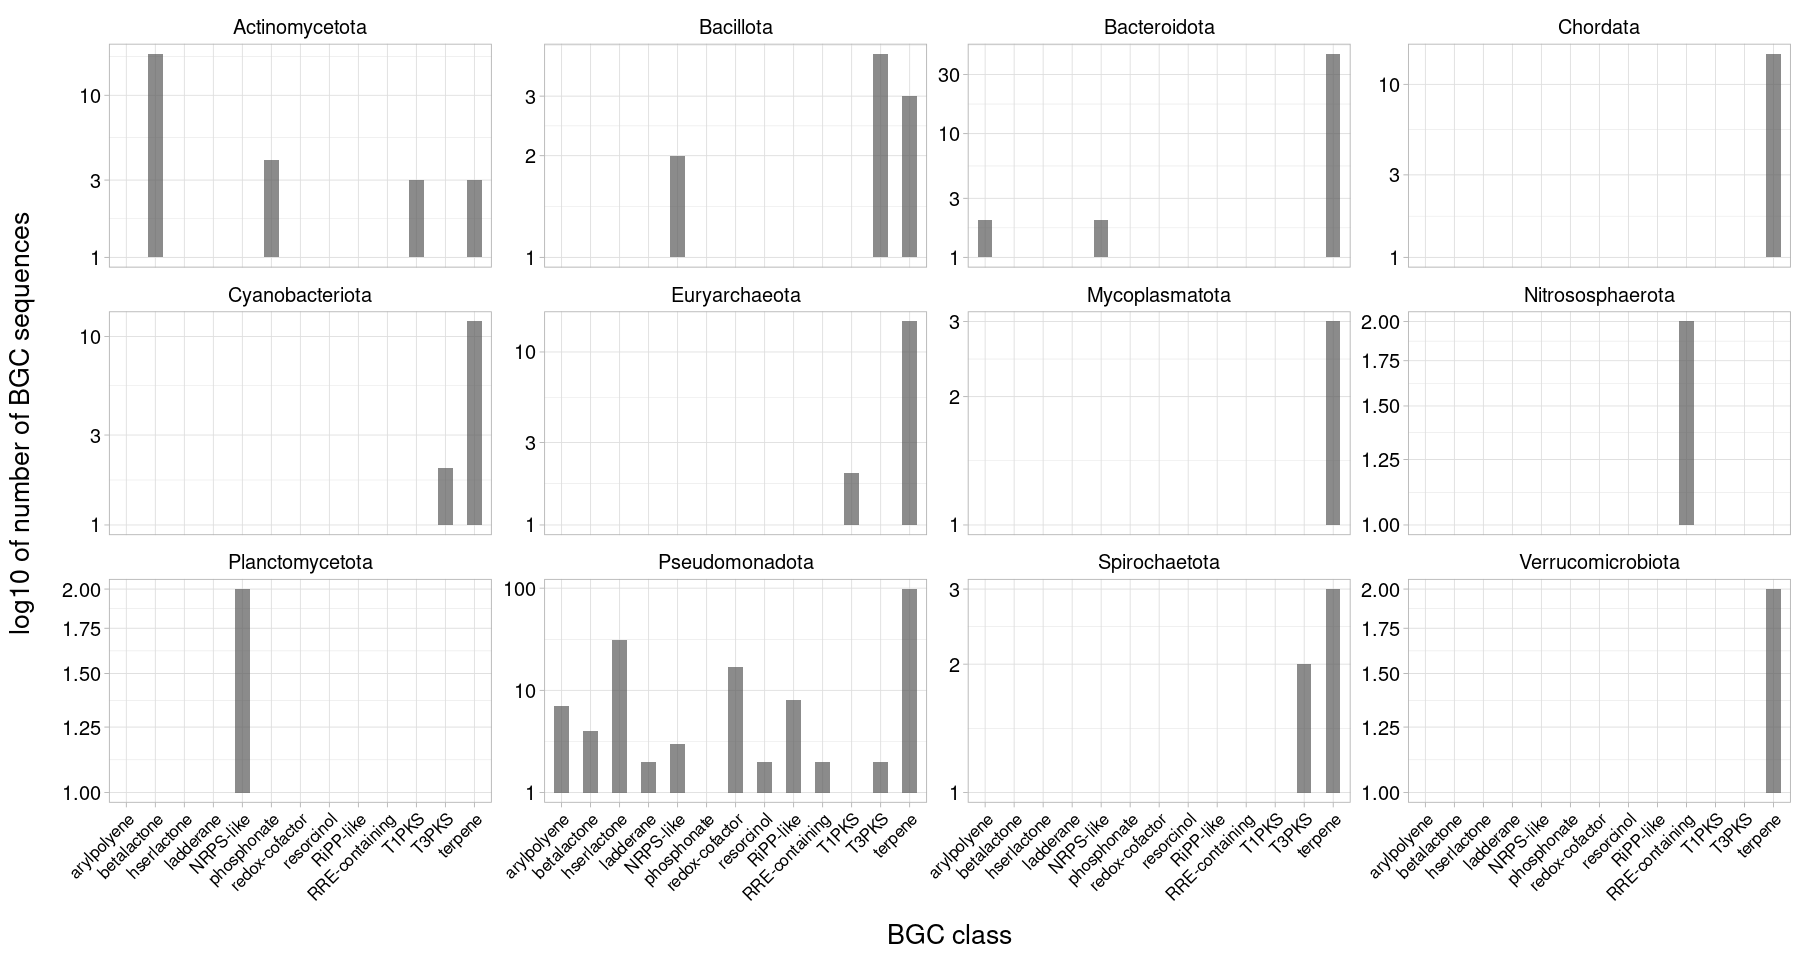

In [465]:
bgc2taxa_counts <- bgc2taxa %>%
                   group_by(phylum, bgc_class) %>%
                   summarize(bgc_seqs_n = unique(seq_id) %>% length) %>%
                   ungroup()

phyla_barplot <- ggplot(data = bgc2taxa_counts, aes(x = bgc_class, y = bgc_seqs_n +1)) + 
                 facet_wrap(~phylum, scales = "free_y") +
                 geom_bar(stat = "identity", width = 0.5, alpha = 0.7) +
                 xlab("BGC class") +
                 ylab("log10 of number of BGC sequences") +
                 scale_y_log10() +
                 theme_light() +
                 theme( 
                       axis.text.x = element_text(size = text_size -2, angle = 45, hjust = 1, color = "black"),
                       axis.text.y = element_text(size = text_size, color = "black"),
                       axis.title.x = element_text(size = text_size + 4, color = "black",
                                                   margin = margin(10,0,0,0)),
                       axis.title.y = element_text(size = text_size + 4, color = "black",
                                                   margin = margin(0,15,0,0)),
                       legend.text = element_text(size = text_size +2, color = "black"),
                       legend.title = element_text(size = text_size +4 , color = "black"),
                       legend.position = "right",
                       legend.margin = ggplot2::margin(0,0,-5,0),
                       strip.background = element_blank(),
                        strip.text = element_text(color = "black", size = text_size)) +
                 guides(fill = guide_legend(keywidth = 0.6, keyheight = 0.6)) 

options(repr.plot.width=15, repr.plot.height=8)
phyla_barplot
